# 灌溉面积扩张结果

In [2]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import salem
import numpy as np

In [3]:
## time range 1850-2014
ds = xr.open_dataset("/mnt/e/Research_life/AWM/Desktop/包含灌溉和雨养面积的nc文件/landuse-totals_histsoc_annual_1850_2014.nc",decode_times=False)
ds

<xarray.Dataset>
Dimensions:             (time: 165, lat: 360, lon: 720)
Coordinates:
  * lat                 (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon                 (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time                (time) float64 189.0 190.0 191.0 ... 351.0 352.0 353.0
Data variables:
    cropland_irrigated  (time, lat, lon) float32 ...
    cropland_rainfed    (time, lat, lon) float32 ...
    cropland_total      (time, lat, lon) float32 ...
    pastures            (time, lat, lon) float32 ...
Attributes: (12/14)
    source:            LUH2 v2h: Land-Use Harmonization Data Set
    institution:       University of Maryland College Park
    host:              UMD College Park
    comment:           LUH2
    contact:           gchurtt@umd.edu, lchini@umd.edu, steve.frolking@unh.ed...
    source_id:         LUH2 v2h
    ...                ...
    institution2:      Potsdam Institute for Climate Impact Research
    comment2:          Aggregated to 0.5 degree spatial resolution from origi...
    original_title:    Land-Use Harmonization Data Sets
    title:             ISIMIP2a ext historical land-use dataset
    contact2:          info@isimip.org
    references:        G. Hurtt, L. Chini, R. Sahajpal, S. Frolking, et al. “...

In [4]:
ds_1982 = ds['cropland_irrigated'][132,::].loc[70:4,70:130]
ds_2000 = ds['cropland_irrigated'][150,::].loc[70:4,70:130]
ds_2018 = (ds['cropland_irrigated'][164,::].loc[70:4,70:130])*0.9866 

In [5]:
shp_path="/mnt/e/Research_life/ArcGIS/西北片区省界/西北片区省界/西北片区省界.shp"
def MaskRegion(ds, region='OBJECTID'):
    shp = gpd.read_file(shp_path)
    if region != 'OBJECTID':
        shp = shp.loc[region, :]
        # shp = shp.loc[[120000], :] 
    ds_mask = ds.salem.roi(shape=shp)
    return ds_mask

In [6]:
ds_1982_mask = MaskRegion(ds_1982,'OBJECTID') 
ds_2000_mask = MaskRegion(ds_2000,'OBJECTID') 
ds_2018_mask = MaskRegion(ds_2018,'OBJECTID') 

In [7]:
ds_1982_mask.values[ds_1982_mask.values==0] = np.nan
ds_2000_mask.values[ds_2000_mask.values==0] = np.nan
ds_2018_mask.values[ds_2018_mask.values==0] = np.nan

In [8]:
print(np.nanmax(ds_1982_mask.values))
print(np.nanmax(ds_2000_mask.values))
print(np.nanmax(ds_2018_mask.values))

0.4552977
0.5349926
0.5222902


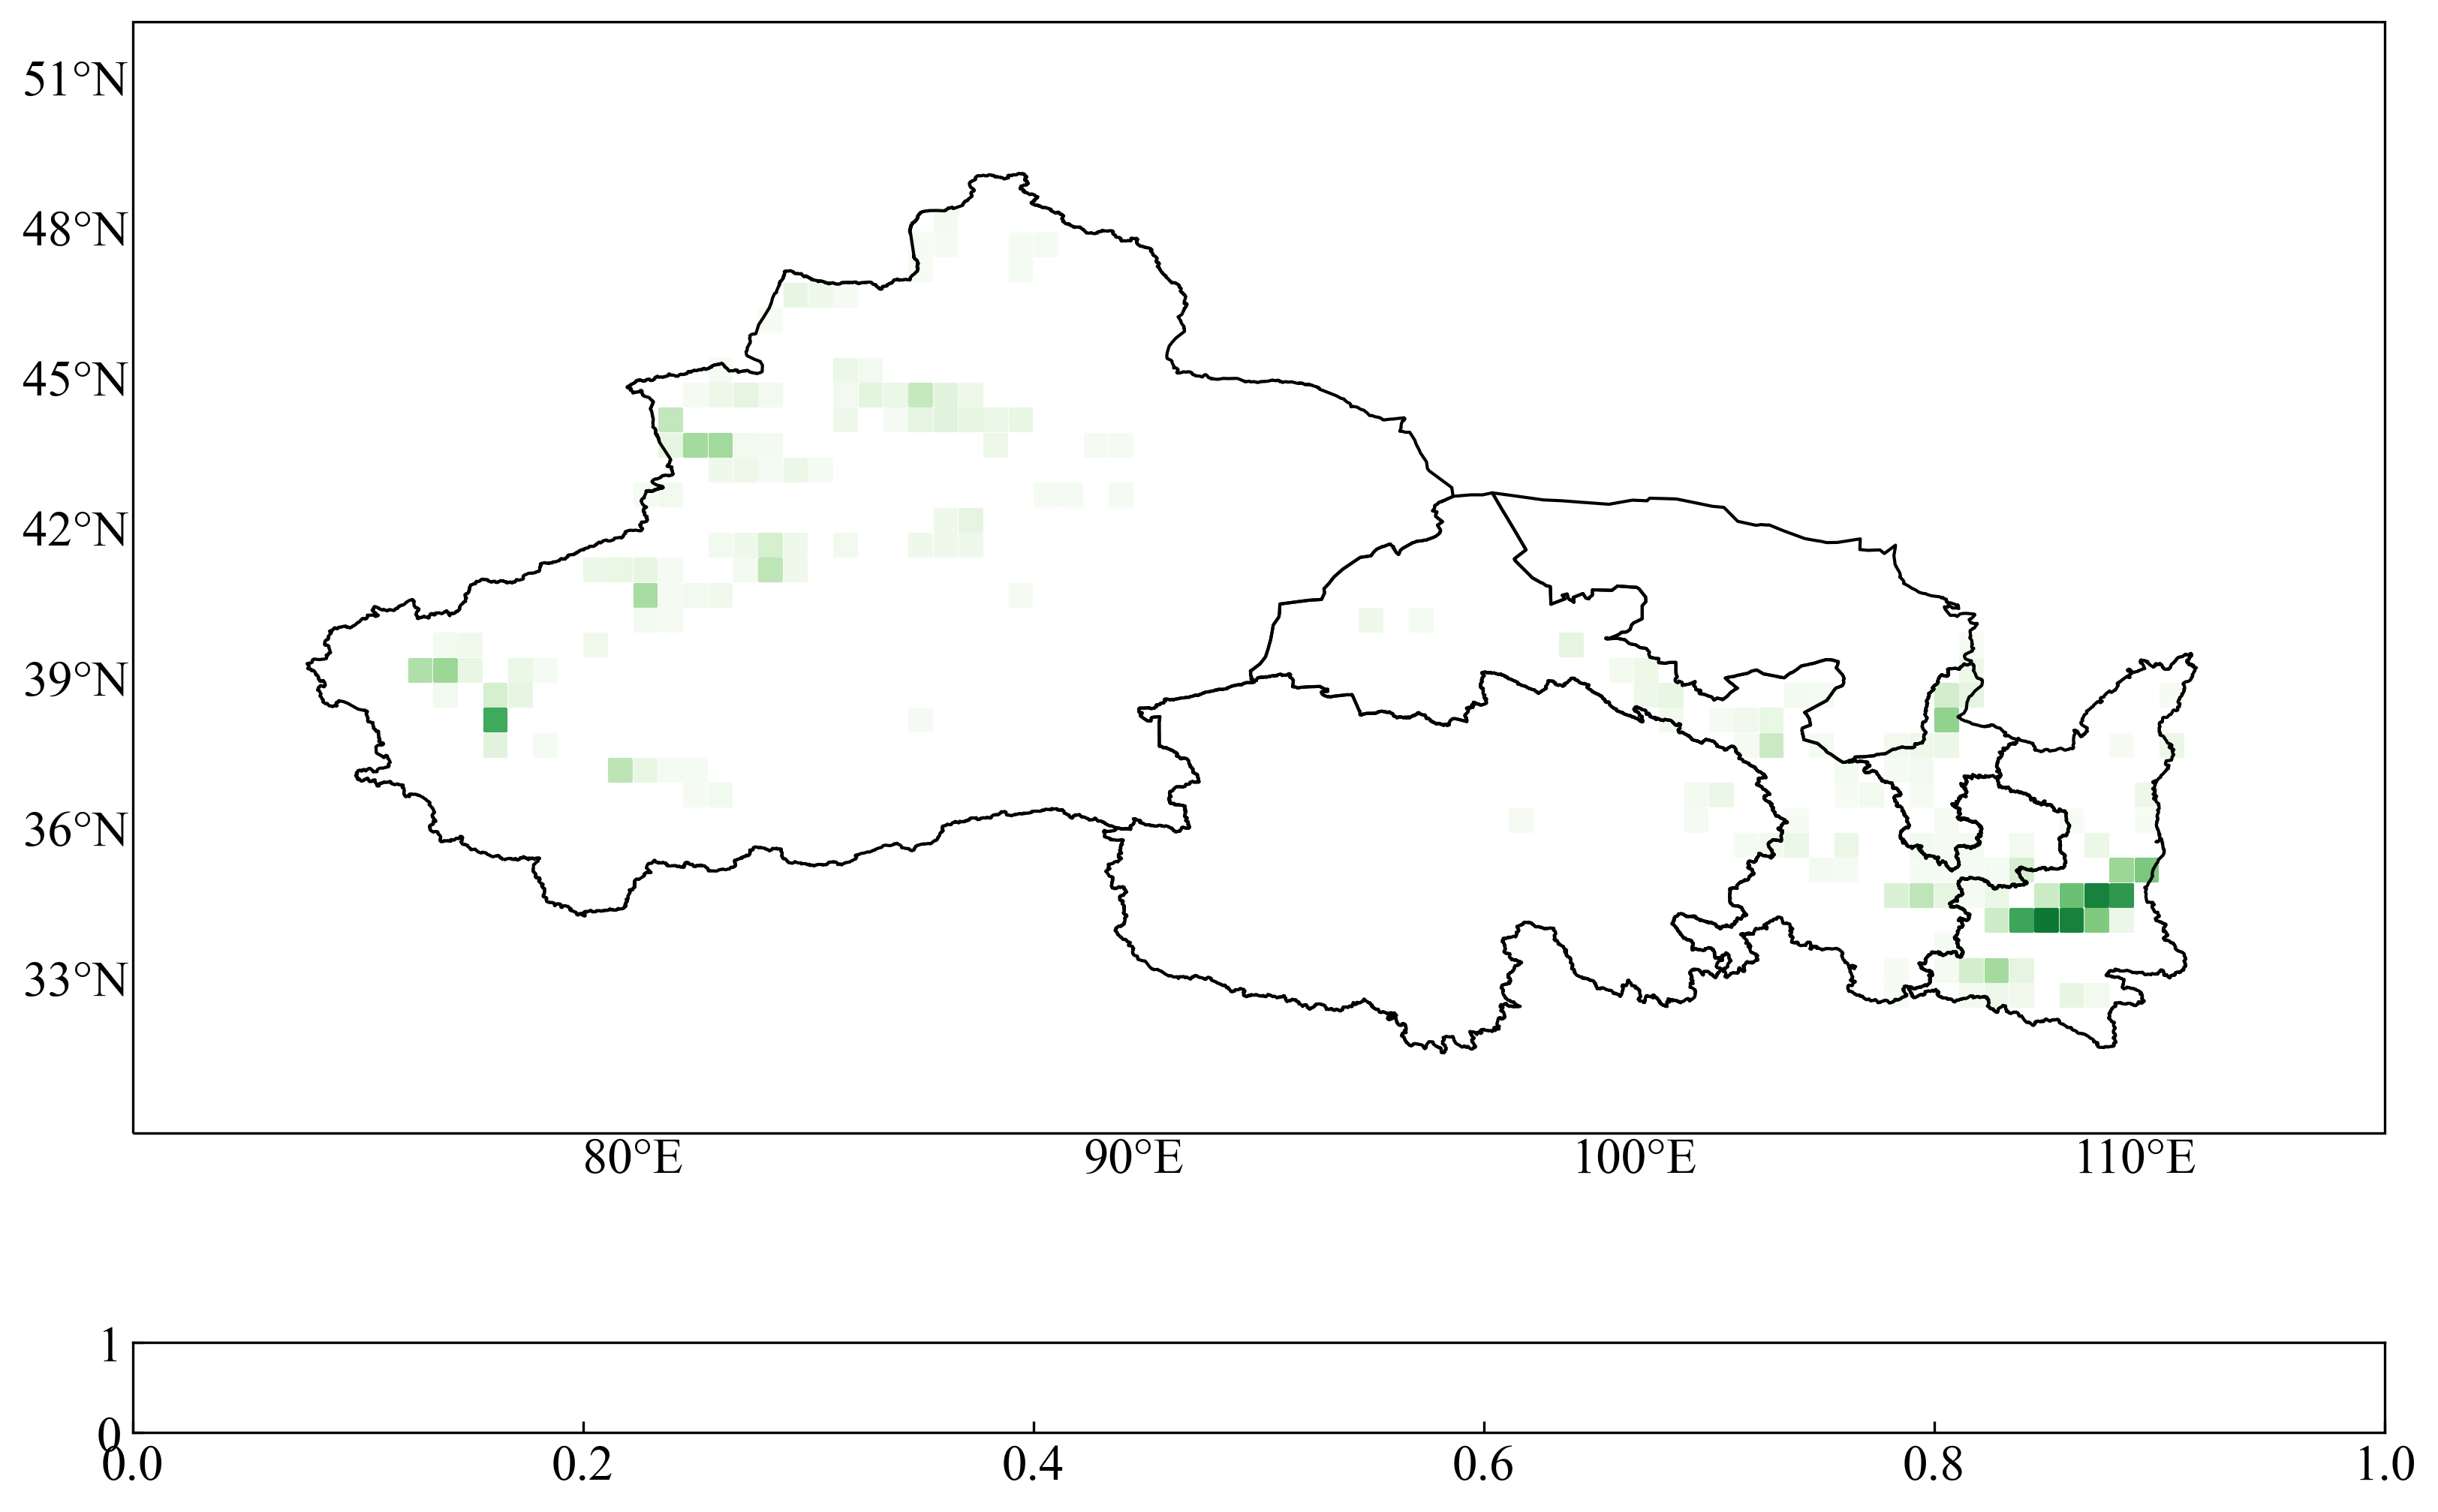

In [18]:
def graph_yellow_river(lon,lat,data,fig_a): # txt site-data # judge whether fig a or b 
    ## graph
    import cartopy.crs as ccrs
    import matplotlib as mpl
    import cmaps
    from matplotlib import rcParams
    import matplotlib.pyplot as plt
    import cartopy.io.shapereader as shpreader
    from cartopy.io.shapereader import Reader, natural_earth
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    config = {
        'font.family':'Times New Roman',
        'font.size':16,
        'axes.unicode_minus':False

    }
    rcParams.update(config)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    # chinese_font = FontProperties(fname='/mnt/e/Research_life/cyq/微软雅黑.ttf')

    # data = DATA['slope1']
    fig = plt.figure(figsize=(20,20), dpi = 300)
    proj = ccrs.PlateCarree()

    # 使图一colorbar映射在同一水平
    # norm1 = mpl.colors.Normalize(vmin=-abs(np.nanmax(slope1)), vmax=abs(np.nanmax(slope1)))

    levels = [0,0.002,0.004]
    ## graph one
    ax1 = fig.add_axes([0.1, 0.9, 0.5, 0.5],projection = proj)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    
    if fig_a=='a':
        # ax1.set_title('(a)',loc='left',fontsize=26)
        gl.ylabels_right = False
        gl.xlabels_top = False
    else:
        # ax1.set_title('(b)',loc='right',fontsize=26)
        gl.ylabels_left = False
        gl.xlabels_top = False
    gl.xlines = False
    gl.ylines = False
    china = shpreader.Reader('/mnt/e/Research_life/ArcGIS/西北片区省界/西北片区省界/更改坐标系后/1.shp').geometries()
    ax1.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)
    ax1.set_extent([95,114,32,43], crs = ccrs.PlateCarree())
    # ax1.scatter(lon,lat, p,[np.nanmin(p),0.01,np.nanmax(p)], zorder=1,hatches=['...', None],colors="none", transform=ccrs.PlateCarree())
    # # 设置norm.
    bins = [0.0001, 0.002, 0.004]
    nbin = len(bins) - 1
    norm = mcolors.BoundaryNorm(bins, nbin)
    norm = mpl.colors.Normalize(vmin=0, vmax=0.55)
    # # 设置cmap.
    position1 = fig.add_axes([0.1, 0.96, 0.5, 0.02])
    color = ['#e0aea4','#c8cc89']
    cmap = mcolors.ListedColormap(color)
    cmap = cm.get_cmap(cmap,nbin)
    cmap.set_under('#9e1e71')
    cmap.set_over('#636e2e')
    c1 = ax1.scatter(lon,lat,s=48,marker='s',zorder=0,c=data,transform=ccrs.PlateCarree(),
                     cmap=cmaps.MPL_Greens,
                     norm=norm
                     )
    # cbar=fig.colorbar(c1,cax=position1,orientation='horizontal',format='%.2f',
    #                 #   extend='both'
    #                   )
    ax1.set_extent([70,115,30,50])
    #添加色标，position定义色标位置，c1指定从c1填色图层取色，由于C3,C1的levles相同，所以色标一致，orientation设置色标为水平还是垂直，format设置色标标签格式
    # cbar.set_label('趋势变化',fontproperties=chinese_font,fontsize = 16)
    return


nx,ny = np.meshgrid(ds_1982_mask['lon'].values,ds_1982_mask['lat'].values)
graph_yellow_river(nx.reshape(-1,1),ny.reshape(-1,1),ds_1982_mask.values.reshape(-1,1),'a')

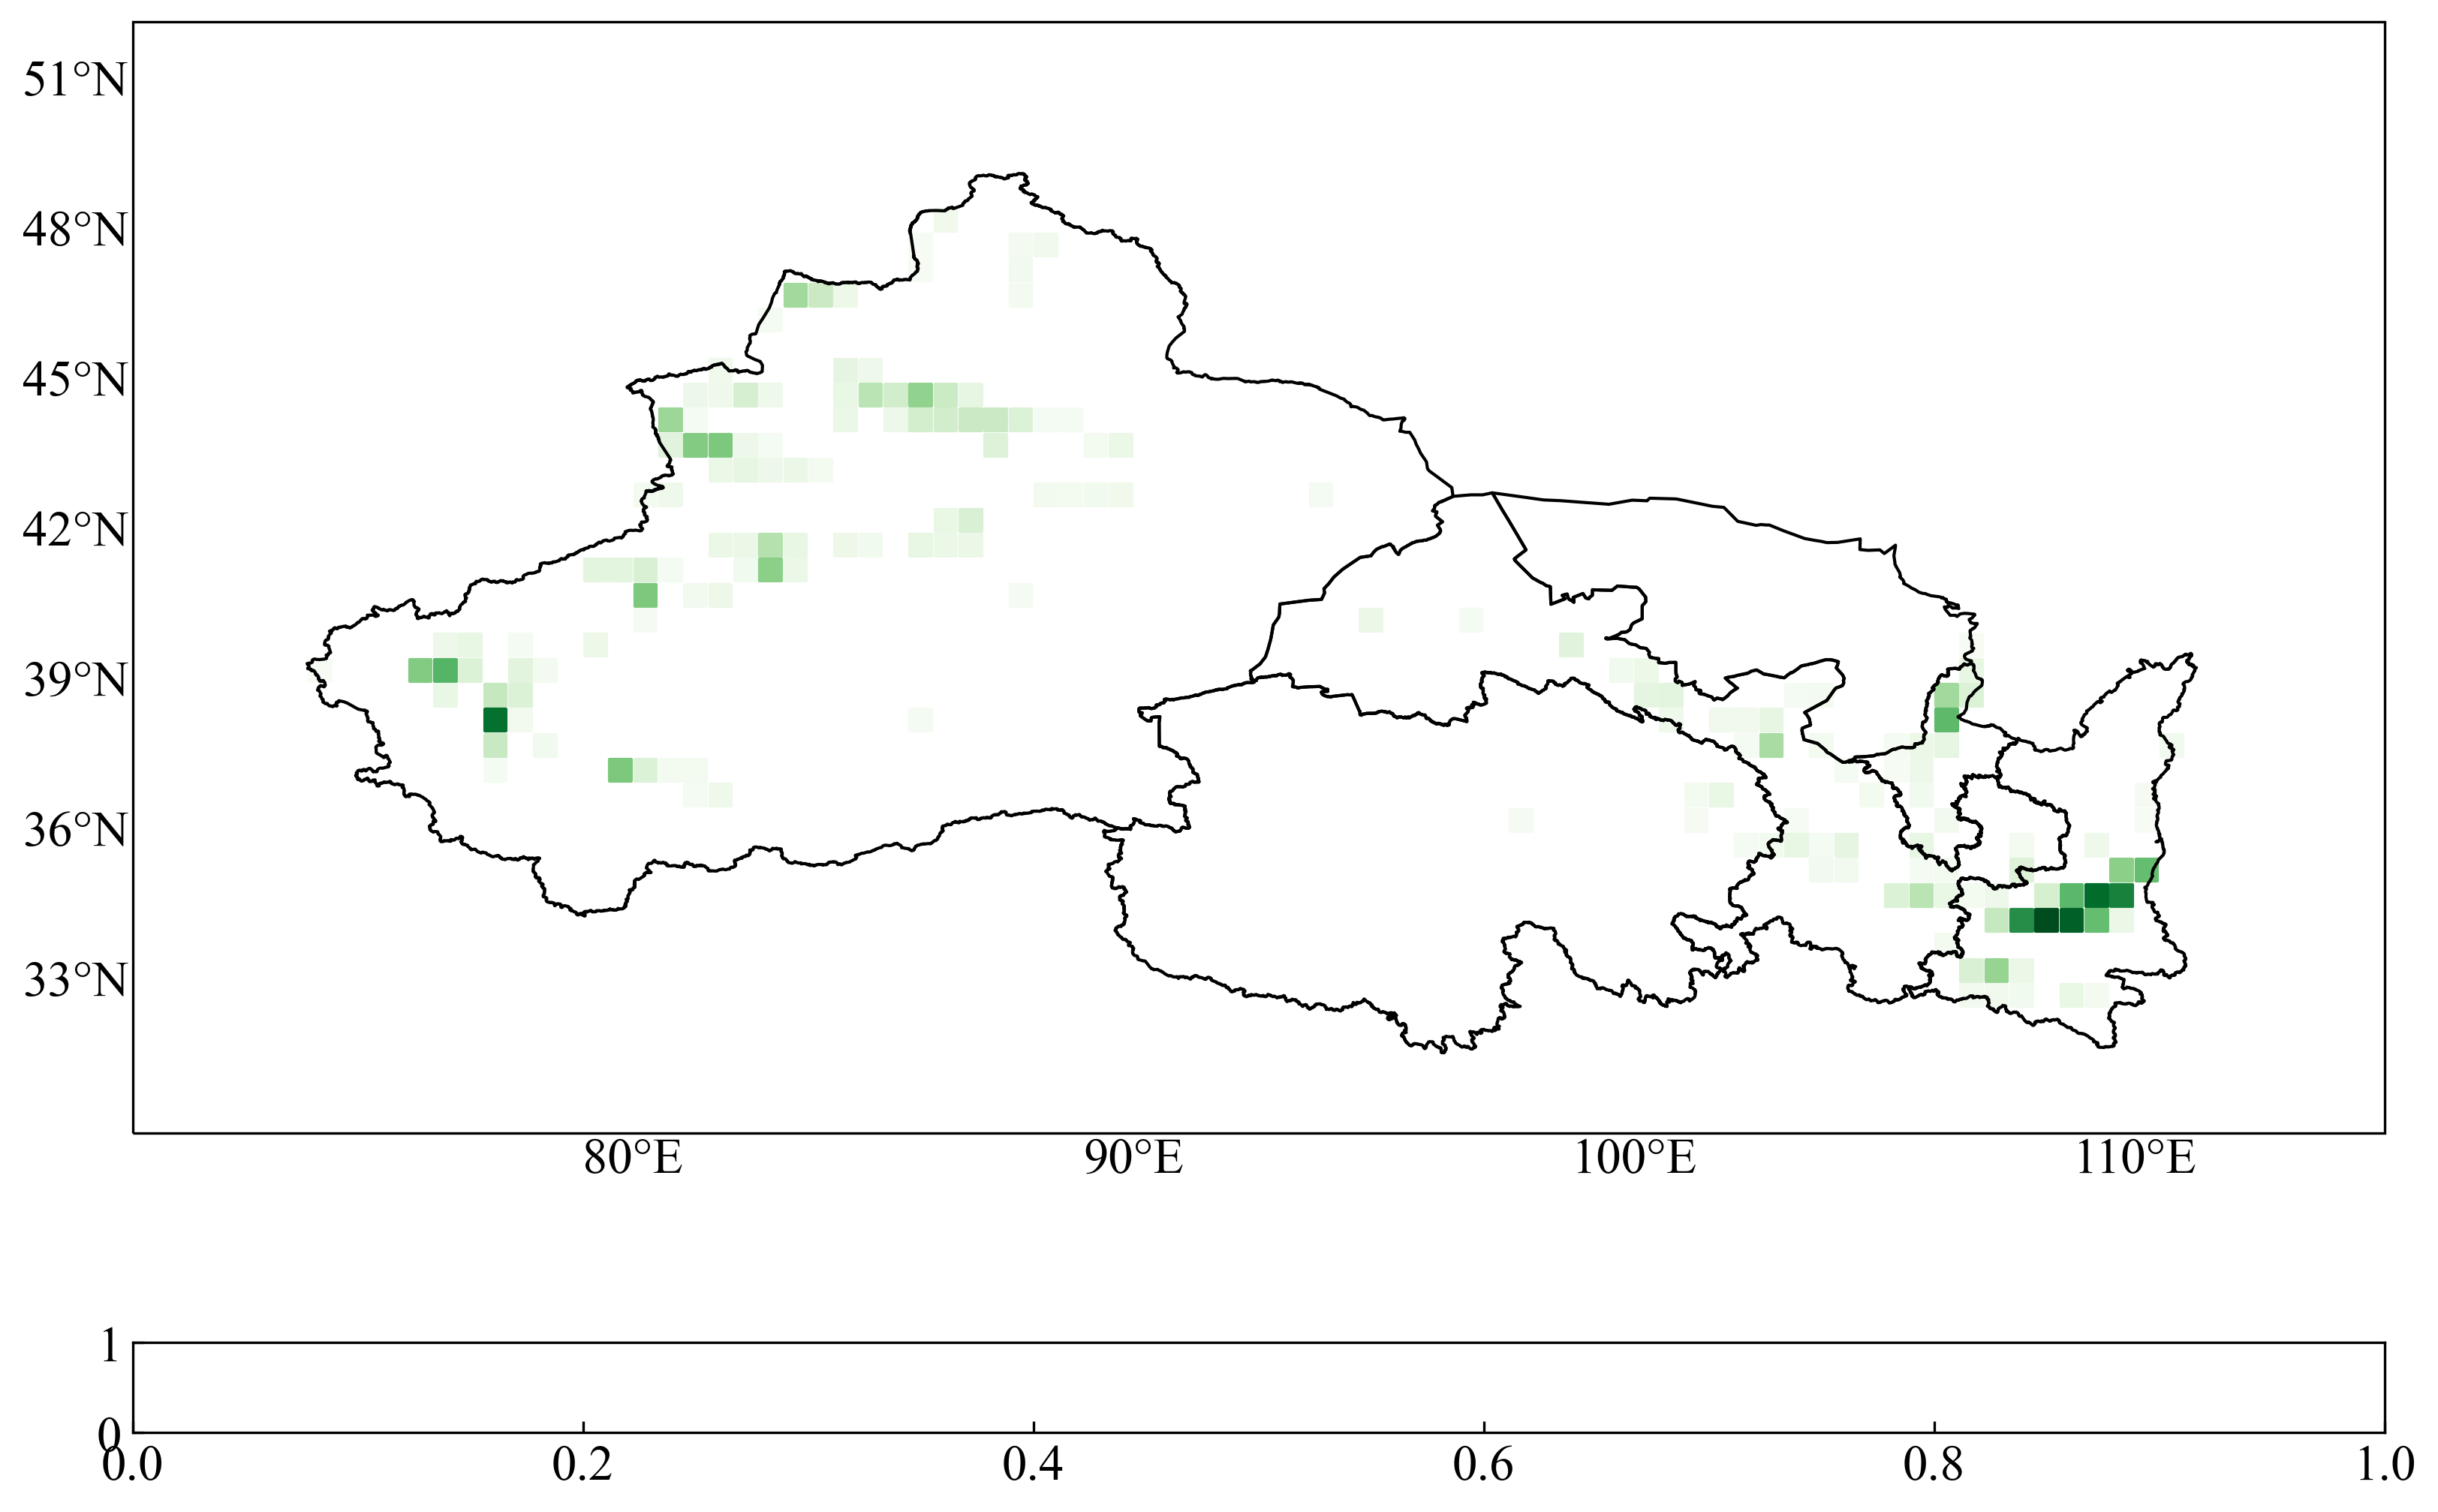

In [19]:
nx,ny = np.meshgrid(ds_2000_mask['lon'].values,ds_2000_mask['lat'].values)
graph_yellow_river(nx.reshape(-1,1),ny.reshape(-1,1),ds_2000_mask.values.reshape(-1,1),'a')

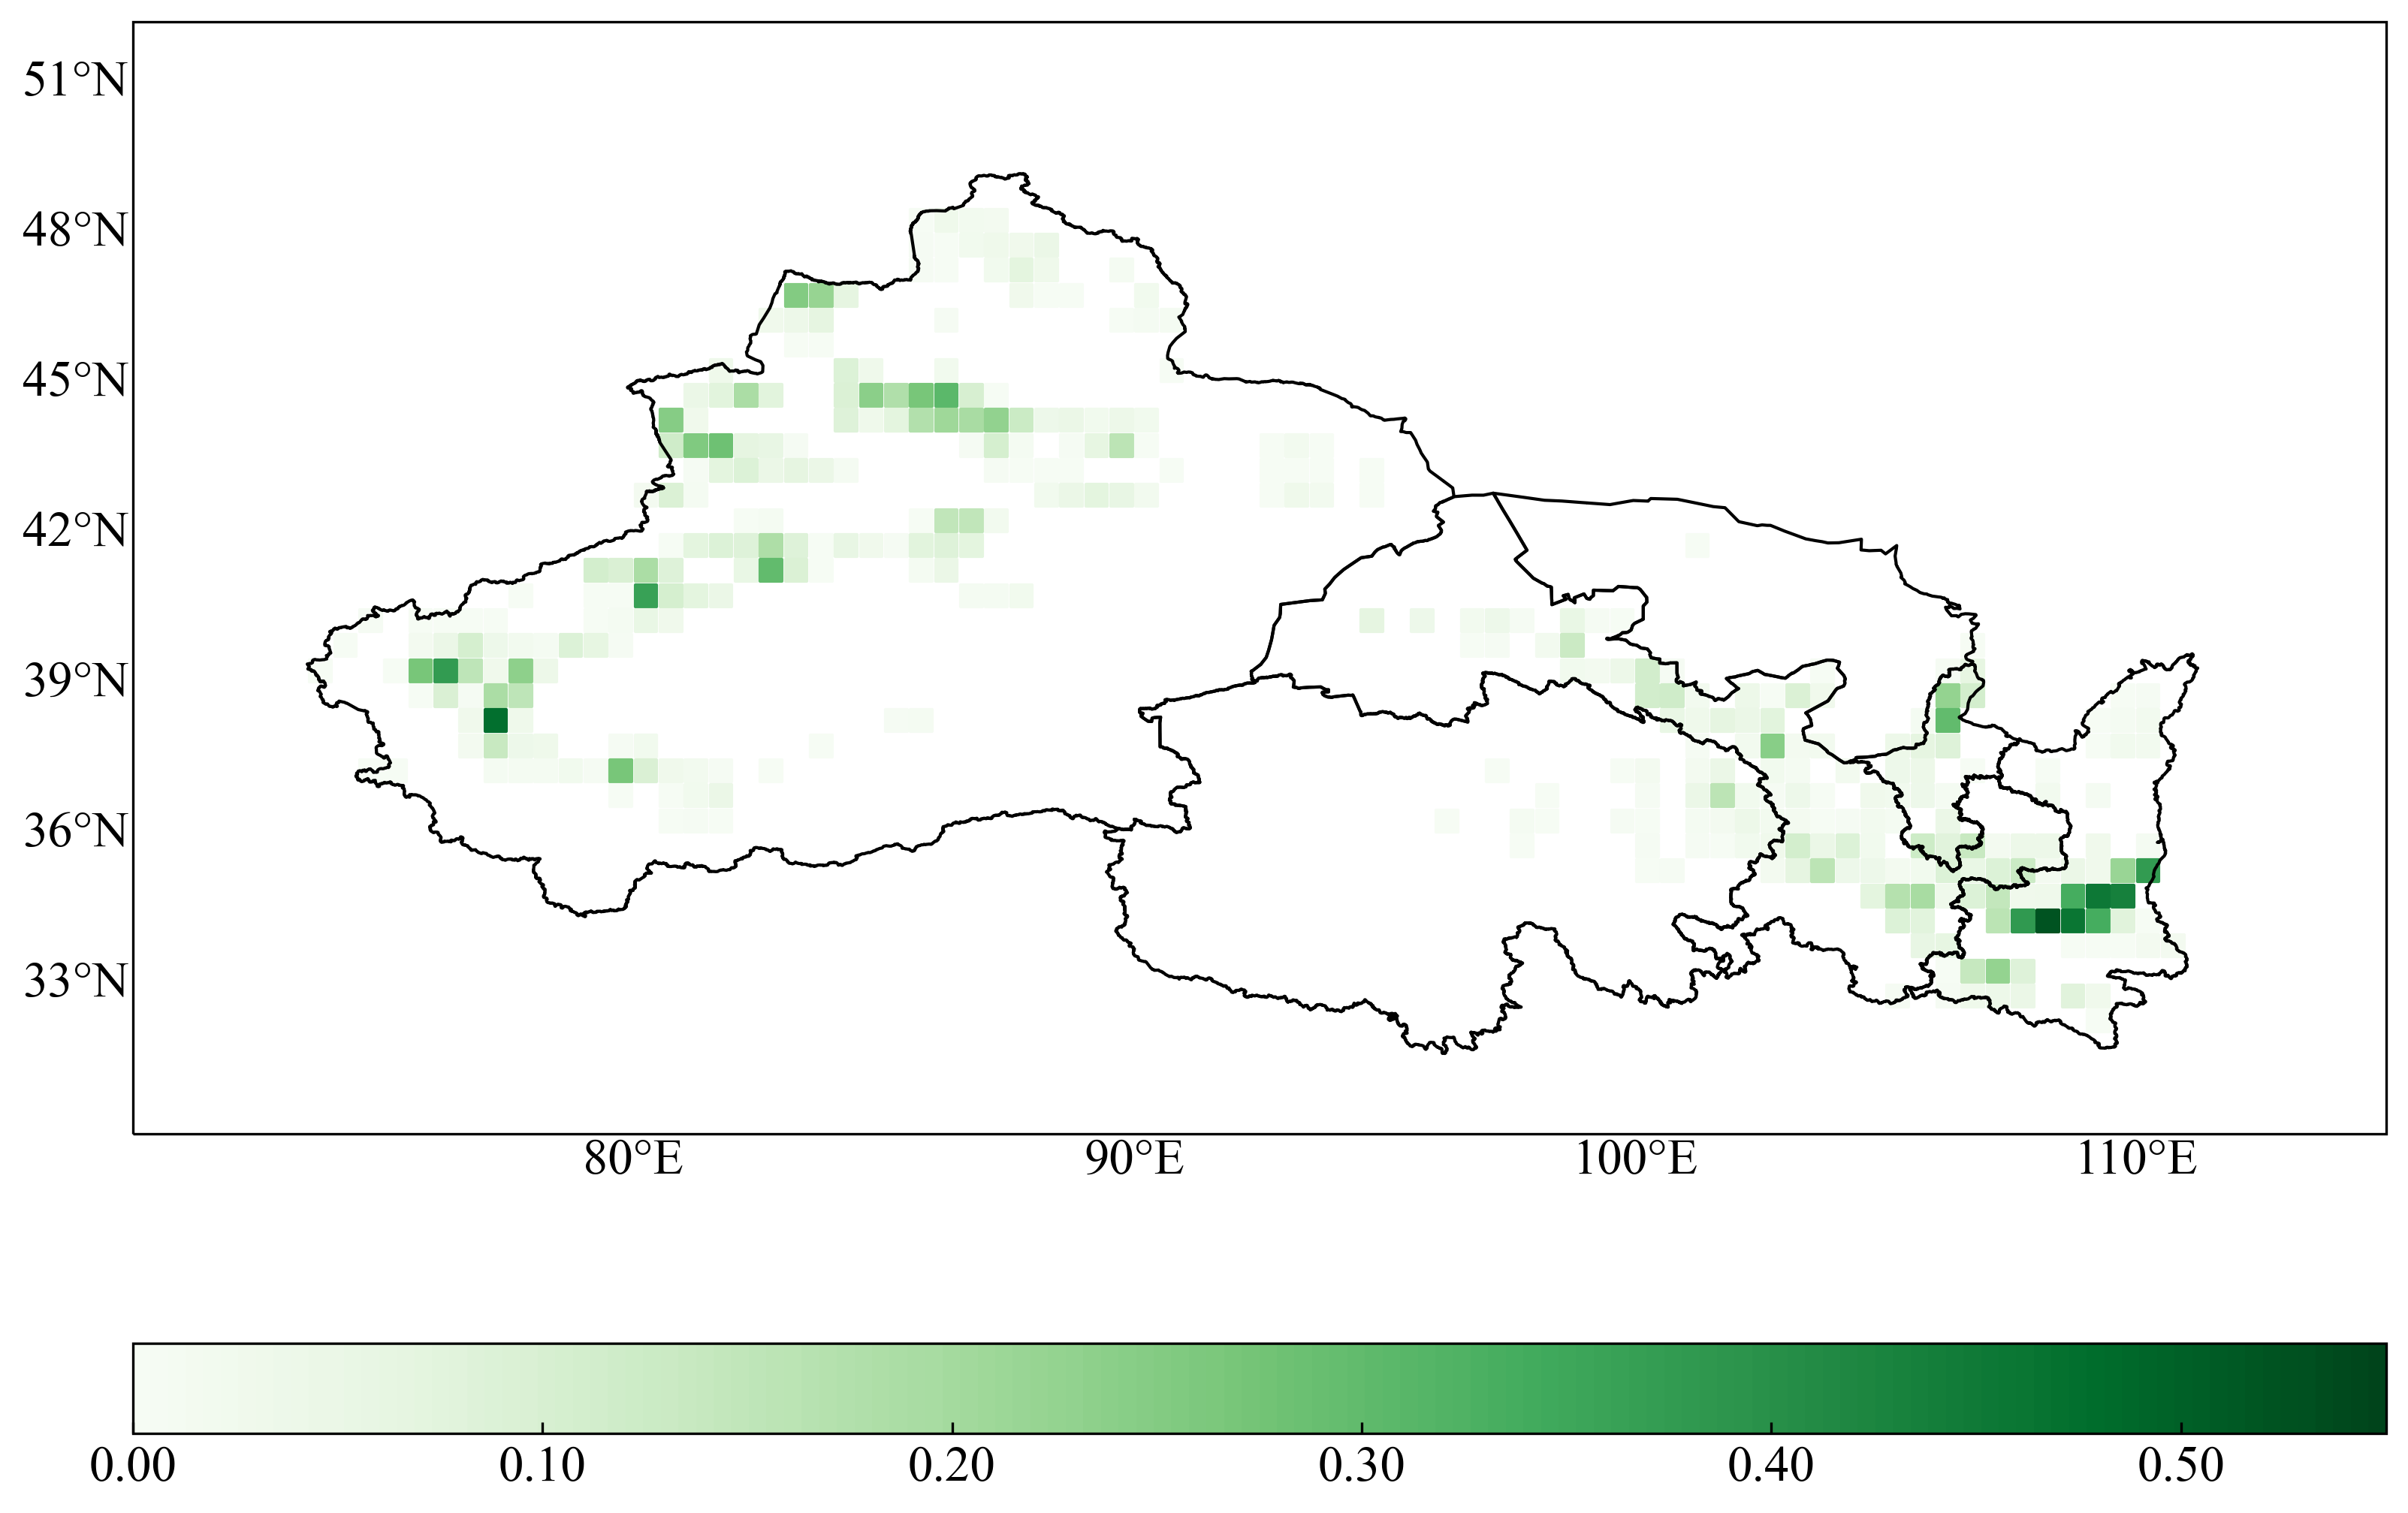

In [15]:
nx,ny = np.meshgrid(ds_2018_mask['lon'].values,ds_2018_mask['lat'].values)
graph_yellow_river(nx.reshape(-1,1),ny.reshape(-1,1),ds_2018_mask.values.reshape(-1,1),'a')

# 提取土地利用为林地的网格坐标

In [86]:
import xarray as xr

In [87]:
ds = xr.open_dataset("/mnt/e/Research_life/AWM/Desktop/多种土地利用类型/2018/GLASS15B02.V40.A2018001.2020343.hdf",engine='netcdf4')['GLASSLandCover']
ds
ds_mask = ds.where(ds.values==1,np.nan)

In [88]:
import xarray as xr
#创建nc文件
nc_dict = {}
#导入纬度信息
nc_dict['lat'] = {'dims':('lat',),'data':np.linspace(18.1541667,53.5541668,708)}
#导入经度信息
nc_dict['lon'] = {'dims':('lon',),'data':np.linspace(73.4458323,135.0958323,1233)}
#导入湿度hurs信息
nc_dict['lc'] = {'dims':('lat','lon'),'data':np.flipud(ds_mask.values)}
ds_lc = xr.Dataset.from_dict(nc_dict)


In [89]:
shp_path="/mnt/e/Research_life/ArcGIS/西北片区省界/西北片区省界/西北片区省界.shp"
def MaskRegion(ds, region='OBJECTID'):
    shp = gpd.read_file(shp_path)
    if region != 'OBJECTID':
        shp = shp.loc[region, :]
        # shp = shp.loc[[120000], :] 
    ds_mask = ds.salem.roi(shape=shp)
    return ds_mask

In [90]:
ds_lc_mask = MaskRegion(ds_lc['lc'],'OBJECTID') 


In [91]:
LC_origin = ds_lc_mask.interp(
    lat = np.arange(32,49.5,0.5),
    lon = np.arange(74,111.5,0.5),
    method='nearest',
    kwargs={
        "fill_value":"extrapolate"
        }
    )

/home/jasper/miniconda3/envs/jay/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/jasper/miniconda3/envs/jay/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/jasper/miniconda3/envs/jay/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/jasper/miniconda3/envs/jay/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

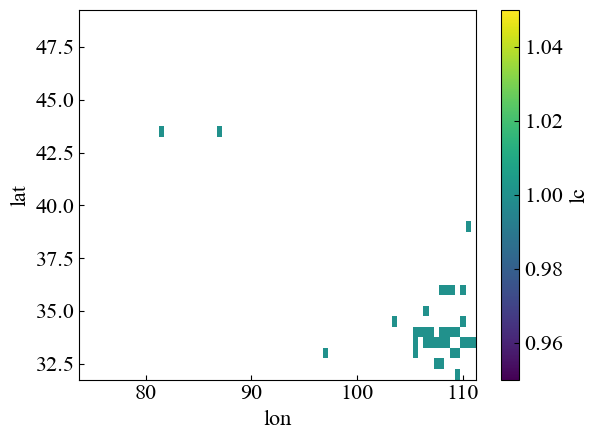

In [93]:
LC_origin.plot()

/home/jasper/miniconda3/envs/jay/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/jasper/miniconda3/envs/jay/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


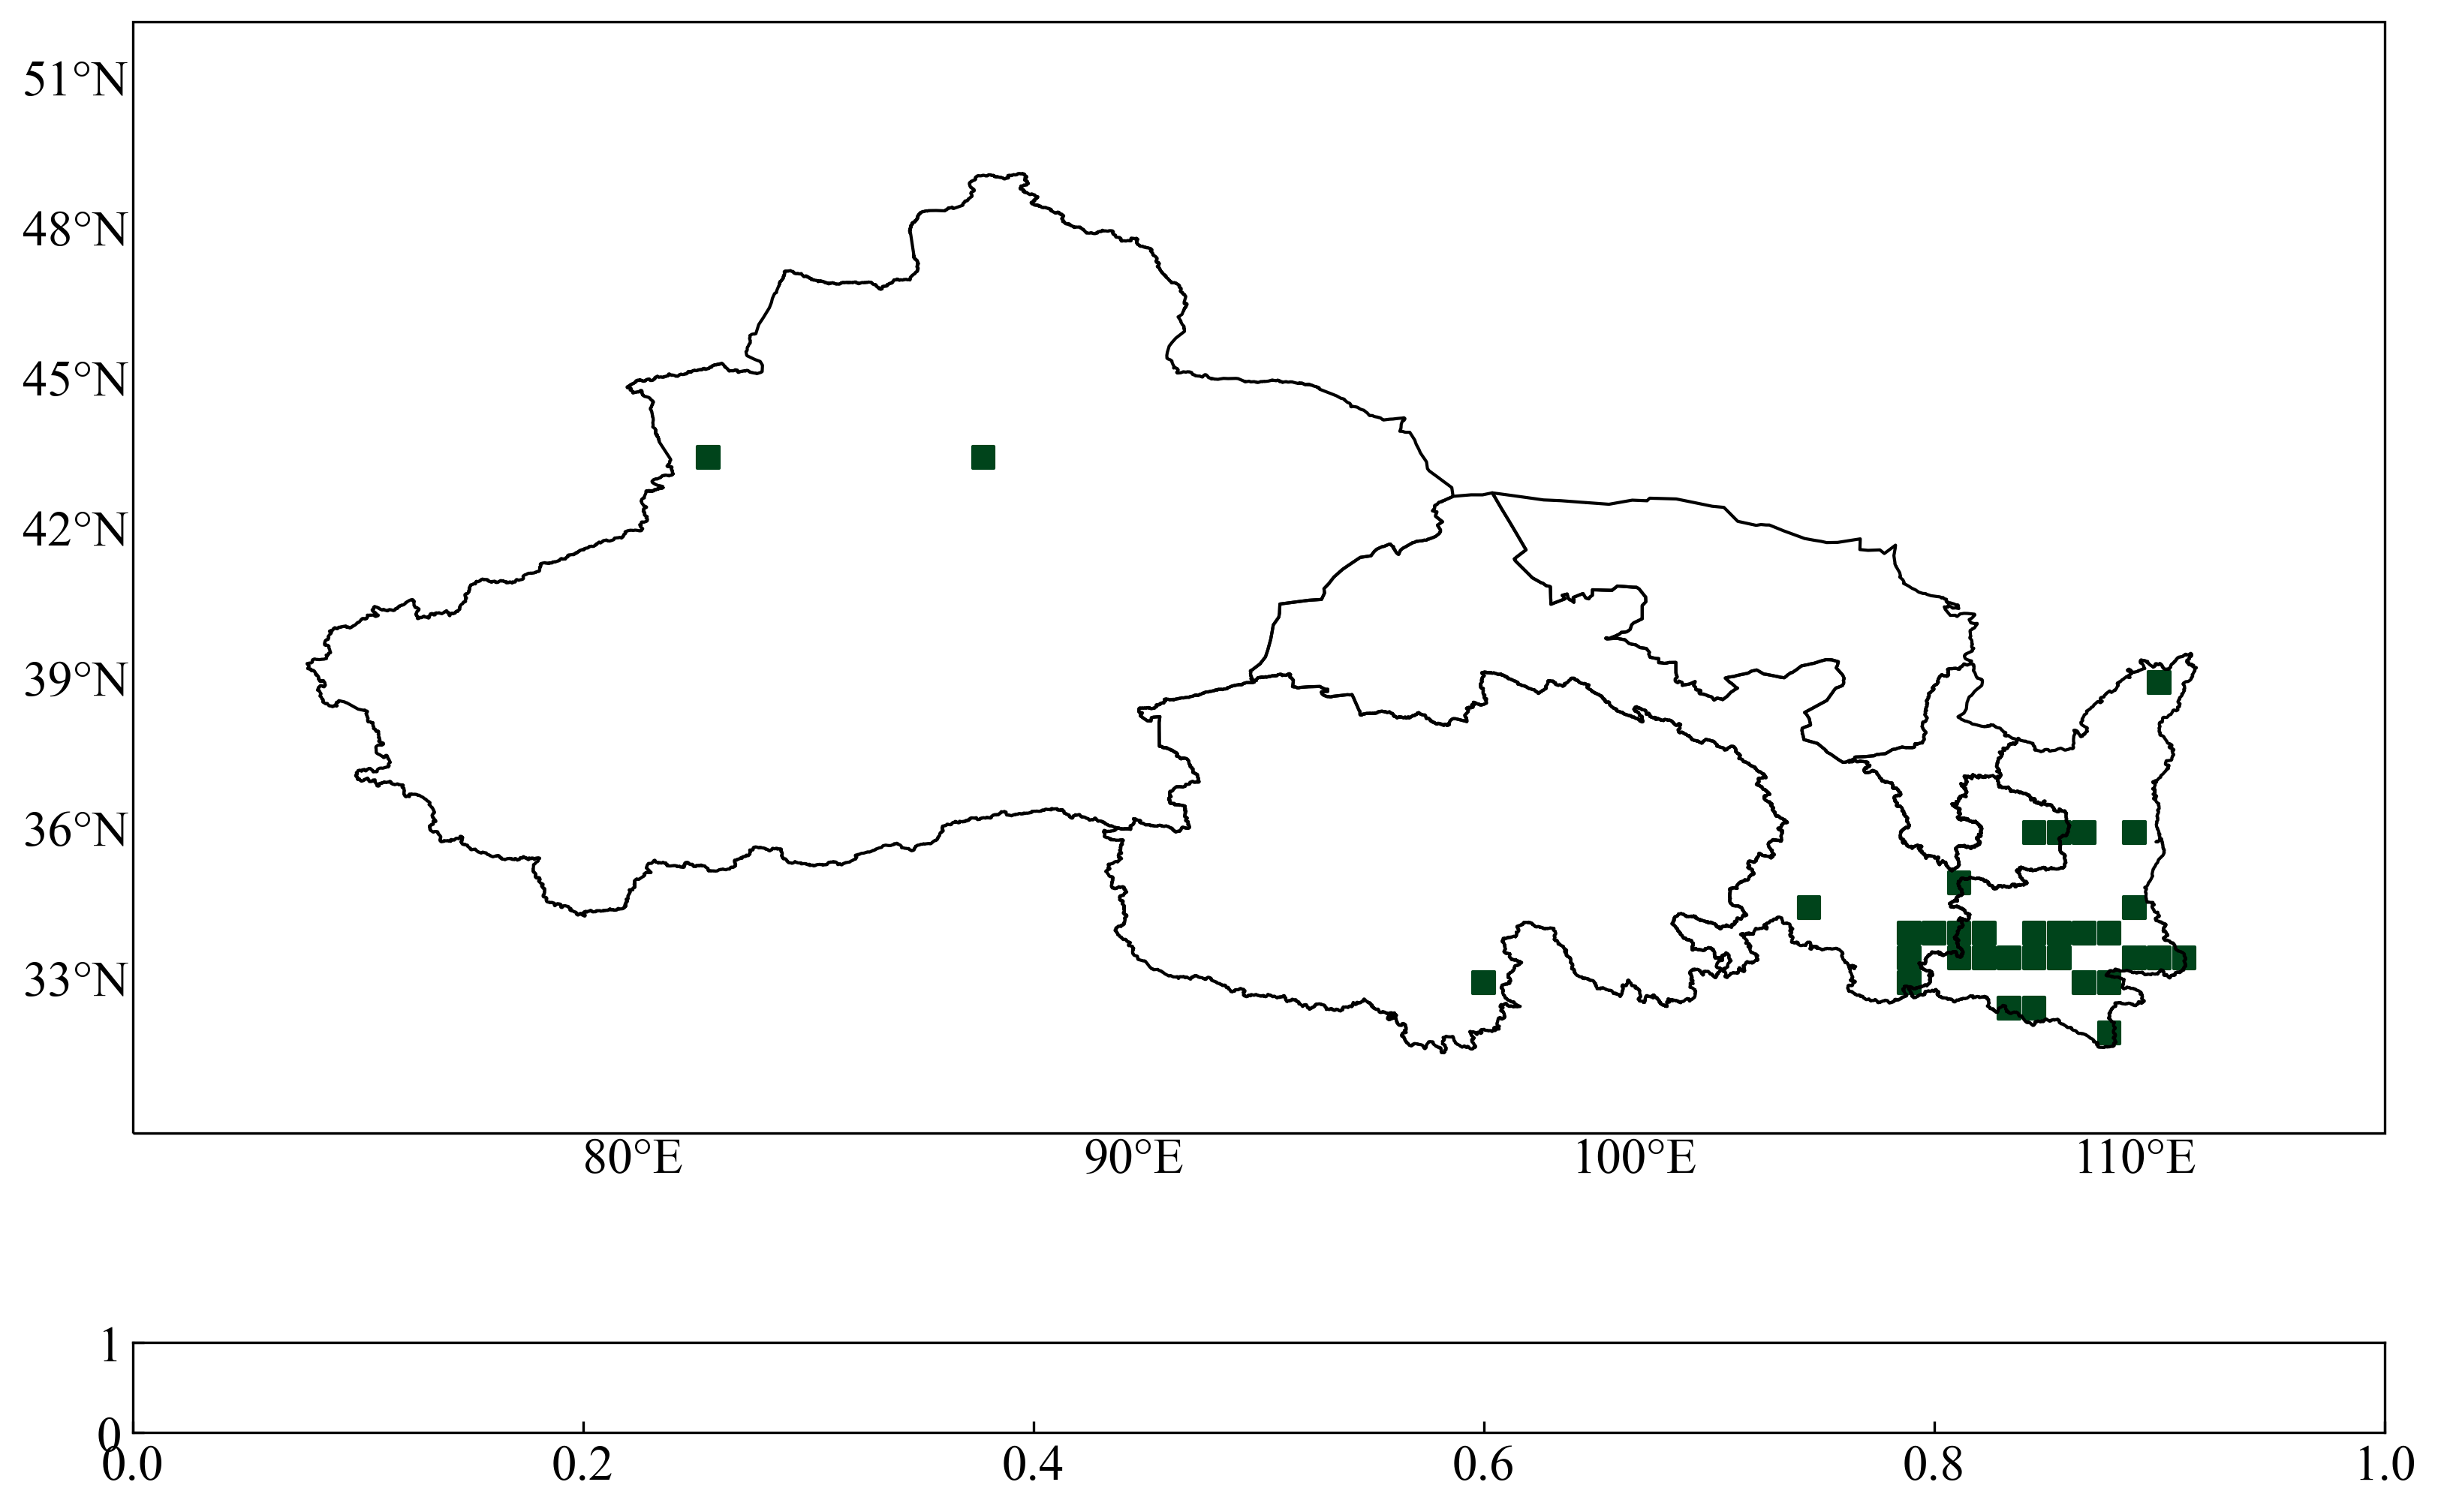

In [94]:
def graph_yellow_river(lon,lat,data,fig_a): # txt site-data # judge whether fig a or b 
    ## graph
    import cartopy.crs as ccrs
    import matplotlib as mpl
    import cmaps
    from matplotlib import rcParams
    import matplotlib.pyplot as plt
    import cartopy.io.shapereader as shpreader
    from cartopy.io.shapereader import Reader, natural_earth
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    config = {
        'font.family':'Times New Roman',
        'font.size':16,
        'axes.unicode_minus':False

    }
    rcParams.update(config)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    # chinese_font = FontProperties(fname='/mnt/e/Research_life/cyq/微软雅黑.ttf')

    # data = DATA['slope1']
    fig = plt.figure(figsize=(20,20), dpi = 300)
    proj = ccrs.PlateCarree()

    # 使图一colorbar映射在同一水平
    # norm1 = mpl.colors.Normalize(vmin=-abs(np.nanmax(slope1)), vmax=abs(np.nanmax(slope1)))

    levels = [0,0.002,0.004]
    ## graph one
    ax1 = fig.add_axes([0.1, 0.9, 0.5, 0.5],projection = proj)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.2, color='k', alpha=0.5, linestyle='--')
    
    if fig_a=='a':
        # ax1.set_title('(a)',loc='left',fontsize=26)
        gl.ylabels_right = False
        gl.xlabels_top = False
    else:
        # ax1.set_title('(b)',loc='right',fontsize=26)
        gl.ylabels_left = False
        gl.xlabels_top = False
    gl.xlines = False
    gl.ylines = False
    china = shpreader.Reader('/mnt/e/Research_life/ArcGIS/西北片区省界/西北片区省界/更改坐标系后/1.shp').geometries()
    ax1.add_geometries(china, ccrs.PlateCarree(),facecolor='none', edgecolor='black',zorder = 1)
    ax1.set_extent([95,114,32,43], crs = ccrs.PlateCarree())
    # ax1.scatter(lon,lat, p,[np.nanmin(p),0.01,np.nanmax(p)], zorder=1,hatches=['...', None],colors="none", transform=ccrs.PlateCarree())
    # # 设置norm.
    bins = [0.0001, 0.002, 0.004]
    nbin = len(bins) - 1
    norm = mcolors.BoundaryNorm(bins, nbin)
    norm = mpl.colors.Normalize(vmin=0, vmax=0.55)
    # # 设置cmap.
    position1 = fig.add_axes([0.1, 0.96, 0.5, 0.02])
    color = ['#e0aea4','#c8cc89']
    cmap = mcolors.ListedColormap(color)
    cmap = cm.get_cmap(cmap,nbin)
    cmap.set_under('#9e1e71')
    cmap.set_over('#636e2e')
    c1 = ax1.scatter(lon,lat,s=48,marker='s',zorder=0,c=data,transform=ccrs.PlateCarree(),
                     cmap=cmaps.MPL_Greens,
                     norm=norm
                     )
    # cbar=fig.colorbar(c1,cax=position1,orientation='horizontal',format='%.2f',
    #                 #   extend='both'
    #                   )
    ax1.set_extent([70,115,30,50])
    #添加色标，position定义色标位置，c1指定从c1填色图层取色，由于C3,C1的levles相同，所以色标一致，orientation设置色标为水平还是垂直，format设置色标标签格式
    # cbar.set_label('趋势变化',fontproperties=chinese_font,fontsize = 16)
    return


nx,ny = np.meshgrid(LC_origin['lon'].values,LC_origin['lat'].values)
graph_yellow_river(nx.reshape(-1,1),ny.reshape(-1,1),LC_origin.values.reshape(-1,1),'a')

In [100]:
data = pd.DataFrame({'1':LC_origin.values.reshape(-1,),
                    '2':nx.reshape(-1,),
                    '3':ny.reshape(-1,)

   })

In [103]:
data = data.dropna()

In [105]:
data.to_csv("/mnt/e/Research_life/AWM/lindi.csv")